In [73]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import cross_validation as cv

In [74]:
daneS = 'OrderBookSnapshots.csv';
with open(daneS, 'r') as f:
    dane = f.readlines()

In [75]:
# Klasa przechowująca wszystkie potrzebne dane o danym lobie,
# tzn. ciąg bid'ów, ask'ów (kwoty i ilości), mid price i zmianę,
# oczywiście zmiana mówi nam o tym, czy w nastepnym lobie zmienił
# się mid price względem tego loba
class LOB:
    def __init__(self, wiersz):
        self.zmiana = 0
        self.dzien = wiersz[0]
        self.czas = wiersz[1]
        i = 3
        while (wiersz[i] != 'ASK'):
            i += 1
        bid = wiersz[3:i]
        ask = wiersz[(i+1):]
        self.bid = np.zeros((int((len(bid) / 2)), 2))
        self.ask = np.zeros((int((len(ask) / 2)), 2))
        for i in range(0, len(bid), 2):
            self.bid[int(i / 2)][0] = float(bid[i]) 
            self.bid[int(i / 2)][1] = float(bid[i+1])
        for i in range(0, len(ask), 2):
            self.ask[int(i / 2)] = [float(ask[i]), float(ask[i+1])]
        self.midPrice = (self.bid[len(self.bid) - 1][0] + self.ask[0][0]) / 2
    def __str__(self):
        return "Dzień: " + self.dzien + ", Czas: " + self.czas + ", midPrice: " + str(self.midPrice)

In [76]:
# przetwarzamy dane, X3 i X4 przydadzą się poźniej
X = []
X3 = []
X4 = []
for wiersz in dane:
    newWiersz = wiersz.split()
    X.append(LOB(newWiersz))
    X3.append(LOB(newWiersz))
    X4.append(LOB(newWiersz))
X = np.array(X)
X3 = np.array(X3)
X4 = np.array(X4)

In [77]:
# przykład ciągu bid'ów dla danego loba
X[0].bid

array([[   630.,  10000.],
       [   635.,  15200.],
       [   639.,   2500.],
       [   640.,   8000.],
       [   642.,   8000.],
       [   645.,   3000.],
       [   650.,  53800.],
       [   660.,  20757.],
       [   662.,  25000.],
       [   665.,  23000.],
       [   670.,   8000.]])

In [78]:
# ustawianie wartości zmian i tworzenie dla nich osobnego wektora
def generujZmiane(X):
    for i in range(len(X) - 1):
        if (X[i].midPrice > X[i + 1].midPrice):
            X[i].zmiana = 1
        if (X[i].midPrice < X[i + 1].midPrice):
            X[i].zmiana = -1
        if (X[i].midPrice == X[i + 1].midPrice):
            X[i].zmiana = 0
    T = generujIndeksy(X)
    return np.array([i.zmiana for i in X])[T]

# interesują nas te loby, po którch nastąpiła zmiana mid price
def generujIndeksy(X):
    return np.arange(len(X))[np.array([(i.zmiana != 0) for i in X])]

In [79]:
# pierwszy sposób - imbalance to różnica najlepszego bid'a i ask'a przez ich sumę
def generujImbalance1(X):
    T = generujIndeksy(X)
    i = 0
    Imbalance1 = np.zeros((T.shape[0], 1))
    for wiersz in X[T]:
        bid = wiersz.bid[-1, 1]
        ask = wiersz.ask[0, 1]
        Imbalance1[i] = (bid - ask) / (bid + ask)
        i += 1
    return Imbalance1

In [80]:
zmiana = generujZmiane(X)
Imbalance1 = generujImbalance1(X)

In [81]:
#nasza (bardziej uczciwa niż wbudowana) cross validacja
def crossValidation(classifier, data, dataClass, k):
    size = data.shape[0]
    arr = np.arange(size)
    np.random.shuffle(arr)
    err = 0
    n = int(size / k)
    for i in range(k):
        mask2 = arr[np.arange(i*n,min((i+1)*n,size))]
        mask1 = arr[np.concatenate((np.arange(i*n),np.arange((i+1)*n,size)))]
        classifier.fit(data[mask1], dataClass[mask1])
        err += classifier.score(data[mask2], dataClass[mask2])
    return float(err) / k 

In [82]:
# Definicja svm i drzewa
param_grid = {'C': [1, 1e1, 1e2, 1e3, 1e4],
              'gamma': [0.0001, 0.001, 0.01, 0.1], 
             }
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, n_jobs = 5)
drzewo = tree.DecisionTreeClassifier(min_samples_leaf= 25, max_depth= 5)

In [83]:
#funkcja normalizująca dane
def normalizuj(X):
    X_mean = np.mean(X, axis = 0)
    X_std = np.std(X,axis = 0)
    X_std[X_std == 0] = 1
    return ((X - X_mean) / X_std)

In [86]:
# funkcje testujące dany imbalance dla klasyfikatora svm i DecisionTreeClassifier
# dla danych standardowych i znormalizowanych
def testuj(zmiana, imbalance, clf):
    X_train, X_test, y_train, y_test = train_test_split(imbalance, zmiana, test_size=0.20, random_state=42)
    clf = clf.fit(X_train, y_train)
    if isinstance(clf, GridSearchCV):
        clf = clf.best_estimator_
    y_pred = clf.predict(X_test)
    print("score: ", clf.score(X_test, y_test))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("Cross-Vall score:", crossValidation(clf, imbalance, zmiana, 5))
    
def wielkiTest(zmiana, imbalance):
    print("Svm:")
    testuj(zmiana, imbalance, svm)
    print("\nDrzewo:")
    testuj(zmiana, imbalance, drzewo)
    imbalance2 = normalizuj(imbalance)
    print("\nSvm dla danych znormalizowanych:")
    testuj(zmiana, imbalance2, svm)
    print("\nDrzewo dla danych znormalizowanych:")
    testuj(zmiana, imbalance2, drzewo)

In [87]:
wielkiTest(zmiana, Imbalance1)

Svm:
score:  0.544575725027
Confusion matrix:
 [[258 194]
 [230 249]]
Cross-Vall score: 0.5453763440860215

Drzewo:
score:  0.542427497315
Confusion matrix:
 [[267 185]
 [241 238]]
Cross-Vall score: 0.5391397849462365

Svm dla danych znormalizowanych:
score:  0.545649838883
Confusion matrix:
 [[260 192]
 [231 248]]
Cross-Vall score: 0.5470967741935484

Drzewo dla danych znormalizowanych:
score:  0.542427497315
Confusion matrix:
 [[267 185]
 [241 238]]
Cross-Vall score: 0.5316129032258065


In [88]:
# Kolejny prosty imbalance, biorący wysokości słupków z najlepszą ceną kupna i sprzedaży.
# Midprice pozostaje be zmian.
def generujImbalance2(X):
    T = generujIndeksy(X)
    i = 0
    Imbalance2 = np.zeros((T.shape[0], 2))
    for wiersz in X[T]:
        bid = wiersz.bid[-1, 1]
        ask = wiersz.ask[0, 1]
        Imbalance2[i][0] = ask
        Imbalance2[i][1] = bid
        i += 1
    return Imbalance2

In [89]:
Imbalance2 = generujImbalance2(X)
wielkiTest(zmiana, Imbalance2)

Svm:
score:  0.482277121375
Confusion matrix:
 [[447   5]
 [477   2]]
Cross-Vall score: 0.4886021505376344

Drzewo:
score:  0.506981740064
Confusion matrix:
 [[229 223]
 [236 243]]
Cross-Vall score: 0.5150537634408602

Svm dla danych znormalizowanych:
score:  0.520945220193
Confusion matrix:
 [[195 257]
 [189 290]]
Cross-Vall score: 0.5365591397849462

Drzewo dla danych znormalizowanych:
score:  0.506981740064
Confusion matrix:
 [[229 223]
 [236 243]]
Cross-Vall score: 0.5253763440860214


In [90]:
# tablica przechowuje wysokości słupków w każdym ticku dla każdego loba, z tym, że dla bidów jest ujemna
minimum = 100000
maksimum = 0
for wiersz in X:
    bid = wiersz.bid[0, 0]
    ask = wiersz.ask[-1, 0]
    if(ask > maksimum):
        maksimum = ask
    if(bid < minimum):
        minimum = bid
liczbaWspolrzednych = int((maksimum - minimum) * 10 + 1)
tablica = np.zeros((len(X), liczbaWspolrzednych), dtype=int)
i = 0
for wiersz in X:
    for item in wiersz.bid:
        tablica[i][int((item[0] - minimum)*10)] = int(-item[1])
    for item in wiersz.ask:
        tablica[i][int((item[0] - minimum)*10)] = int(item[1])
    i += 1

In [91]:
wielkiTest(zmiana, tablica[generujIndeksy(X)])

Svm:
score:  0.485499462943
Confusion matrix:
 [[452   0]
 [479   0]]
Cross-Vall score: 0.5010752688172043

Drzewo:
score:  0.486573576799
Confusion matrix:
 [[417  35]
 [443  36]]
Cross-Vall score: 0.5

Svm dla danych znormalizowanych:
score:  0.512352309345
Confusion matrix:
 [[232 220]
 [234 245]]
Cross-Vall score: 0.5309677419354839

Drzewo dla danych znormalizowanych:
score:  0.486573576799
Confusion matrix:
 [[417  35]
 [443  36]]
Cross-Vall score: 0.4952688172043011


In [92]:
# dla danego loba ustawia nowy mid price w zależności od ilości akcji
def setNewMidPrice1(lob, k):
    bid = lob.bid
    ask = lob.ask
    bidAmount = 0
    bidValue = 0
    for i in range(bid.shape[0]):
        if ((bidAmount + bid[-(i+1), 1]) <= k):
            bidValue += bid[-(i+1), 1] * bid[-(i+1), 0]
            bidAmount += bid[-(i+1), 1]
        else:
            bidValue += bid[-(i+1), 0] * (k - bidAmount)
            bidAmount = k
            break
    askAmount = 0
    askValue = 0
    for i in range(ask.shape[0]):
        if ((askAmount + ask[i, 1]) <= k):
            askValue += ask[i, 1] * ask[i, 0]
            askAmount += ask[i, 1]
        else:
            askValue += ask[i, 0] * (k - askAmount)
            askAmount = k
            break
    bidPrice = bidValue / bidAmount
    askPrice = askValue / askAmount
    lob.midPrice = (bidPrice + askPrice) / 2
    return (askPrice - bidPrice) / (bidPrice + askPrice)

In [93]:
# ustawiamy nowy imbalance, biorący różnicę cen sprzedaży i kupna k akcji przez ich sumę
def generujDane3(X, k):
    Imbalance3 = np.zeros((len(X), 1))
    i = 0
    for wiersz in X:
        Imbalance3[i] = setNewMidPrice1(wiersz, k)
        i += 1
    zmiana3 = generujZmiane(X)
    Imbalance3 = Imbalance3[generujIndeksy(X)]
    return (zmiana3, Imbalance3)

In [94]:
zmiana3, Imbalance3 = generujDane3(X3, 10000)
wielkiTest(zmiana3, Imbalance3)

Svm:
score:  0.513384321224
Confusion matrix:
 [[528   3]
 [506   9]]
Cross-Vall score: 0.5052631578947369

Drzewo:
score:  0.503824091778
Confusion matrix:
 [[275 256]
 [263 252]]
Cross-Vall score: 0.4943540669856459

Svm dla danych znormalizowanych:
score:  0.48948374761
Confusion matrix:
 [[  0 531]
 [  3 512]]
Cross-Vall score: 0.5052631578947369

Drzewo dla danych znormalizowanych:
score:  0.493307839388
Confusion matrix:
 [[371 160]
 [370 145]]
Cross-Vall score: 0.4949282296650718


In [95]:
# Ustawianie midPrice w zależności od ilości akcji, które możemy kupić za kwotę p
# zaś imbalance jest ustawiany w zależności od kwoty k
def setNewMidPrice2(lob, k, p):
    bid = lob.bid
    ask = lob.ask
    bidAmount = 0
    bidValue = 0
    for i in range(bid.shape[0]):
        if ((bidValue + (bid[-(i+1), 0])*bid[-(i+1), 1]) <= p):
            bidValue += bid[-(i+1), 1] * bid[-(i+1), 0]
            bidAmount += bid[-(i+1), 1]
        else:
            bidAmount += (p - bidValue) / bid[-(i + 1), 0]
            break
    askAmount = 0
    askValue = 0
    for i in range(ask.shape[0]):
        if ((askValue + (ask[i, 0])*ask[i, 1]) <= p):
            askValue += ask[i, 1] * ask[i, 0]
            askAmount += ask[i, 1]
        else:
            askAmount += (p - askValue) / ask[i, 0]
            break
    bidPrice = p / bidAmount
    askPrice = p / askAmount
    lob.midPrice = (bidPrice + askPrice) / 2 

    bidAmount = 0
    bidValue = 0
    for i in range(bid.shape[0]):
        if ((bidValue + (bid[-(i+1), 0])*bid[-(i+1), 1]) <= k):
            bidValue += bid[-(i+1), 1] * bid[-(i+1), 0]
            bidAmount += bid[-(i+1), 1]
        else:
            bidAmount += (k - bidValue) / bid[-(i + 1), 0]
            break
    askAmount = 0
    askValue = 0
    for i in range(ask.shape[0]):
        if ((askValue + (ask[i, 0])*ask[i, 1]) <= k):
            askValue += ask[i, 1] * ask[i, 0]
            askAmount += ask[i, 1]
        else:
            askAmount += (k - askValue) / ask[i, 0]
            break
    return (askAmount - bidAmount) / (bidAmount + askAmount)

In [96]:
# ustawiamy nowy imbalance, biorący różnicę ilości akcji, które możemy sprzedać
# z ilością akcji, które możemy kupić za daną kwotę k, przez ich sumę
def generujDane4(X, k, p):
    Imbalance4 = np.zeros((len(X), 1))
    i = 0
    for wiersz in X:
        Imbalance4[i] = setNewMidPrice2(wiersz, k, p)
        i += 1
    zmiana4 = generujZmiane(X)
    Imbalance4 = Imbalance4[generujIndeksy(X)]
    return (zmiana4, Imbalance4)

In [97]:
zmiana4, Imbalance4 = generujDane4(X4, 5000000, 5000000)
wielkiTest(zmiana4, Imbalance4)

Svm:
score:  0.512030798845
Confusion matrix:
 [[532   0]
 [507   0]]
Cross-Vall score: 0.49961464354527935

Drzewo:
score:  0.496631376323
Confusion matrix:
 [[130 402]
 [121 386]]
Cross-Vall score: 0.494990366088632

Svm dla danych znormalizowanych:
score:  0.512030798845
Confusion matrix:
 [[532   0]
 [507   0]]
Cross-Vall score: 0.5086705202312138

Drzewo dla danych znormalizowanych:
score:  0.487006737247
Confusion matrix:
 [[364 168]
 [365 142]]
Cross-Vall score: 0.48978805394990366


In [98]:
# Mądrzejsza zależność od wykresu, łączymy k tików il razy na lewo i prawo od midprice
def generujPrzedzialy(X, tablica, k, il):
    wynik = np.zeros((len(X), 2 * il))
    i = 0
    for wiersz in X:
        pozMidPrice = int((wiersz.midPrice - minimum) * 10)
        for j in range(il):
            if (pozMidPrice - (j+1) * k >= 0):
                wynik[i][2 * j] = 1/(j+1)*np.sum(tablica[i][(pozMidPrice - (j+1) * k): (pozMidPrice - j * k)])
            else:
                wynik[i][2 * j] = 0
            if (pozMidPrice + (j+1) * k < tablica.shape[1]):
                wynik[i][2 * j + 1] = 1/(j+1)*np.sum(tablica[i][(pozMidPrice + j * k): (pozMidPrice + (j+1) * k)])
            else:
                wynik[i][2 * j + 1] = 0
        i += 1
    return wynik

In [99]:
Imbalance5 = generujPrzedzialy(X, tablica, 5, 10)
wielkiTest(zmiana, Imbalance5[generujIndeksy(X)])

Svm:
score:  0.485499462943
Confusion matrix:
 [[452   0]
 [479   0]]
Cross-Vall score: 0.49204301075268814

Drzewo:
score:  0.512352309345
Confusion matrix:
 [[196 256]
 [198 281]]
Cross-Vall score: 0.5019354838709678

Svm dla danych znormalizowanych:
score:  0.514500537057
Confusion matrix:
 [[241 211]
 [241 238]]
Cross-Vall score: 0.510752688172043

Drzewo dla danych znormalizowanych:
score:  0.512352309345
Confusion matrix:
 [[196 256]
 [198 281]]
Cross-Vall score: 0.5081720430107527


In [100]:
# łączymy tablicę ticków po k tików
def generujPrzedzialy2(tablica, k):
    il = int(tablica.shape[1] / k) + 1
    wynik = np.zeros((tablica.shape[0], il))
    i = 0
    for wiersz in tablica:
        for j in range(il):
            wynik[i] = np.sum(wiersz[j*k:(j+1)*k])
        i += 1
    return wynik

In [101]:
Imbalance5 = generujPrzedzialy2(tablica, 20)
wielkiTest(zmiana, Imbalance5[generujIndeksy(X)])

Svm:
score:  0.514500537057
Confusion matrix:
 [[226 226]
 [226 253]]
Cross-Vall score: 0.5068817204301076

Drzewo:
score:  0.514500537057
Confusion matrix:
 [[226 226]
 [226 253]]
Cross-Vall score: 0.5137634408602151

Svm dla danych znormalizowanych:
score:  0.518796992481
Confusion matrix:
 [[137 315]
 [133 346]]
Cross-Vall score: 0.5129032258064516

Drzewo dla danych znormalizowanych:
score:  0.514500537057
Confusion matrix:
 [[226 226]
 [226 253]]
Cross-Vall score: 0.5094623655913979


In [102]:
# łączymy il przedziałów na lewo i prawo od mid price, z tym,
# że każdy kolejny przedział jest większy od poprzedniego
def generujPrzedzialy3(X, tablica, il):
    wynik = np.zeros((len(X), 2 * il))
    i = 0
    for wiersz in X:
        k1 = 0
        k2 = 1
        pozMidPrice = int((wiersz.midPrice - minimum) * 10)
        for j in range(il):
            if (pozMidPrice - k2 >= 0):
                wynik[i][2 * j] = 1/(j+1)*np.sum(tablica[i][(pozMidPrice - k2): (pozMidPrice - k1)])
            else:
                wynik[i][2 * j] = 0
            if (pozMidPrice + k2 < tablica.shape[1]):
                wynik[i][2 * j + 1] = 1/(j+1)*np.sum(tablica[i][(pozMidPrice + k1): (pozMidPrice + k2)])
            else:
                wynik[i][2 * j + 1] = 0
            k2 = k1
            k2 += (j + 1)
        i += 1
    return wynik

In [103]:
Imbalance6 = generujPrzedzialy3(X, tablica, 20)
wielkiTest(zmiana, Imbalance6[generujIndeksy(X)])

Svm:
score:  0.485499462943
Confusion matrix:
 [[452   0]
 [479   0]]
Cross-Vall score: 0.4969892473118279

Drzewo:
score:  0.500537056928
Confusion matrix:
 [[337 115]
 [350 129]]
Cross-Vall score: 0.5060215053763442

Svm dla danych znormalizowanych:
score:  0.542427497315
Confusion matrix:
 [[152 300]
 [126 353]]
Cross-Vall score: 0.5316129032258065

Drzewo dla danych znormalizowanych:
score:  0.500537056928
Confusion matrix:
 [[337 115]
 [350 129]]
Cross-Vall score: 0.5111827956989247


In [104]:
# na nowo wczytujemy dane, z tym, że pomijamy część danych
# z początku i końca każdego "giełdowego dnia"
X = []
X3 = []
X4 = []

for wiersz in dane:
    newWiersz = wiersz.split()
    if (int(newWiersz[1]) >= 83000000 and int(newWiersz[1]) <= 163000000):
        X.append(LOB(newWiersz))
        X3.append(LOB(newWiersz))
        X4.append(LOB(newWiersz))
X = np.array(X)
X3 = np.array(X3)
X4 = np.array(X4)

In [105]:
zmiana = generujZmiane(X)
Imbalance1 = generujImbalance1(X)

In [106]:
wielkiTest(zmiana, Imbalance1)

Svm:
score:  0.531791907514
Confusion matrix:
 [[250 181]
 [224 210]]
Cross-Vall score: 0.5453703703703704

Drzewo:
score:  0.528323699422
Confusion matrix:
 [[261 170]
 [238 196]]
Cross-Vall score: 0.5324074074074074

Svm dla danych znormalizowanych:
score:  0.534104046243
Confusion matrix:
 [[247 184]
 [219 215]]
Cross-Vall score: 0.5453703703703704

Drzewo dla danych znormalizowanych:
score:  0.528323699422
Confusion matrix:
 [[261 170]
 [238 196]]
Cross-Vall score: 0.5409722222222222


In [107]:
Imbalance2 = generujImbalance2(X)
wielkiTest(zmiana, Imbalance2)

Svm:
score:  0.517919075145
Confusion matrix:
 [[165 266]
 [151 283]]
Cross-Vall score: 0.513888888888889

Drzewo:
score:  0.528323699422
Confusion matrix:
 [[231 200]
 [208 226]]
Cross-Vall score: 0.5247685185185186

Svm dla danych znormalizowanych:
score:  0.515606936416
Confusion matrix:
 [[268 163]
 [256 178]]
Cross-Vall score: 0.5335648148148148

Drzewo dla danych znormalizowanych:
score:  0.528323699422
Confusion matrix:
 [[231 200]
 [208 226]]
Cross-Vall score: 0.513888888888889


In [108]:
minimum = 100000
maksimum = 0
for wiersz in X:
    bid = wiersz.bid[0, 0]
    ask = wiersz.ask[-1, 0]
    if(ask > maksimum):
        maksimum = ask
    if(bid < minimum):
        minimum = bid
liczbaWspolrzednych = int((maksimum - minimum) * 10 + 1)
tablica = np.zeros((len(X), liczbaWspolrzednych), dtype=int)
i = 0
for wiersz in X:
    for item in wiersz.bid:
        tablica[i][int((item[0] - minimum)*10)] = int(-item[1])
    for item in wiersz.ask:
        tablica[i][int((item[0] - minimum)*10)] = int(item[1])
    i += 1

In [109]:
zmiana3, Imbalance3 = generujDane3(X3, 10000)
wielkiTest(zmiana3, Imbalance3)

Svm:
score:  0.491155046826
Confusion matrix:
 [[472   0]
 [489   0]]
Cross-Vall score: 0.49437499999999995

Drzewo:
score:  0.476586888658
Confusion matrix:
 [[307 165]
 [338 151]]
Cross-Vall score: 0.4885416666666666

Svm dla danych znormalizowanych:
score:  0.4901144641
Confusion matrix:
 [[253 219]
 [271 218]]
Cross-Vall score: 0.49333333333333335

Drzewo dla danych znormalizowanych:
score:  0.468262226847
Confusion matrix:
 [[296 176]
 [335 154]]
Cross-Vall score: 0.49124999999999996


In [110]:
zmiana4, Imbalance4 = generujDane4(X4, 5000000, 5000000)
wielkiTest(zmiana4, Imbalance4)

Svm:
score:  0.495815899582
Confusion matrix:
 [[  0 482]
 [  0 474]]
Cross-Vall score: 0.4917277486910995

Drzewo:
score:  0.508368200837
Confusion matrix:
 [[459  23]
 [447  27]]
Cross-Vall score: 0.49340314136125657

Svm dla danych znormalizowanych:
score:  0.495815899582
Confusion matrix:
 [[  0 482]
 [  0 474]]
Cross-Vall score: 0.49130890052356024

Drzewo dla danych znormalizowanych:
score:  0.508368200837
Confusion matrix:
 [[460  22]
 [448  26]]
Cross-Vall score: 0.48900523560209425


In [111]:
Imbalance5 = generujPrzedzialy(X, tablica, 5, 10)
wielkiTest(zmiana, Imbalance5[generujIndeksy(X)])

Svm:
score:  0.498265895954
Confusion matrix:
 [[431   0]
 [434   0]]
Cross-Vall score: 0.49259259259259264

Drzewo:
score:  0.499421965318
Confusion matrix:
 [[373  58]
 [375  59]]
Cross-Vall score: 0.4979166666666667

Svm dla danych znormalizowanych:
score:  0.522543352601
Confusion matrix:
 [[197 234]
 [179 255]]
Cross-Vall score: 0.5219907407407407

Drzewo dla danych znormalizowanych:
score:  0.499421965318
Confusion matrix:
 [[373  58]
 [375  59]]
Cross-Vall score: 0.5127314814814815


In [112]:
Imbalance5 = generujPrzedzialy2(tablica, 20)
wielkiTest(zmiana, Imbalance5[generujIndeksy(X)])

Svm:
score:  0.519075144509
Confusion matrix:
 [[225 206]
 [210 224]]
Cross-Vall score: 0.5148148148148148

Drzewo:
score:  0.517919075145
Confusion matrix:
 [[223 208]
 [209 225]]
Cross-Vall score: 0.5032407407407408

Svm dla danych znormalizowanych:
score:  0.493641618497
Confusion matrix:
 [[ 42 389]
 [ 49 385]]
Cross-Vall score: 0.500462962962963

Drzewo dla danych znormalizowanych:
score:  0.517919075145
Confusion matrix:
 [[223 208]
 [209 225]]
Cross-Vall score: 0.5085648148148147


In [113]:
Imbalance6 = generujPrzedzialy3(X, tablica, 20)
wielkiTest(zmiana3, Imbalance6[generujIndeksy(X3)])

Svm:
score:  0.491155046826
Confusion matrix:
 [[472   0]
 [489   0]]
Cross-Vall score: 0.490625

Drzewo:
score:  0.501560874089
Confusion matrix:
 [[ 78 394]
 [ 85 404]]
Cross-Vall score: 0.48895833333333333

Svm dla danych znormalizowanych:
score:  0.530697190427
Confusion matrix:
 [[197 275]
 [176 313]]
Cross-Vall score: 0.5043749999999999

Drzewo dla danych znormalizowanych:
score:  0.501560874089
Confusion matrix:
 [[ 78 394]
 [ 85 404]]
Cross-Vall score: 0.49416666666666675


In [114]:
# testujemy najsensowniejsze imbalance z róznymi zmianami
Imbalance6 = generujPrzedzialy3(X, tablica, 20)
wielkiTest(zmiana, Imbalance6[generujIndeksy(X)])
wielkiTest(zmiana3, Imbalance6[generujIndeksy(X3)])
wielkiTest(zmiana4, Imbalance6[generujIndeksy(X4)])

Svm:
score:  0.498265895954
Confusion matrix:
 [[431   0]
 [434   0]]
Cross-Vall score: 0.48171296296296295

Drzewo:
score:  0.515606936416
Confusion matrix:
 [[173 258]
 [161 273]]
Cross-Vall score: 0.5166666666666666

Svm dla danych znormalizowanych:
score:  0.509826589595
Confusion matrix:
 [[106 325]
 [ 99 335]]
Cross-Vall score: 0.5275462962962963

Drzewo dla danych znormalizowanych:
score:  0.51098265896
Confusion matrix:
 [[171 260]
 [163 271]]
Cross-Vall score: 0.512962962962963
Svm:
score:  0.491155046826
Confusion matrix:
 [[472   0]
 [489   0]]
Cross-Vall score: 0.4883333333333333

Drzewo:
score:  0.501560874089
Confusion matrix:
 [[ 78 394]
 [ 85 404]]
Cross-Vall score: 0.5075

Svm dla danych znormalizowanych:
score:  0.530697190427
Confusion matrix:
 [[197 275]
 [176 313]]
Cross-Vall score: 0.499375

Drzewo dla danych znormalizowanych:
score:  0.501560874089
Confusion matrix:
 [[ 78 394]
 [ 85 404]]
Cross-Vall score: 0.5004166666666666
Svm:
score:  0.504184100418
Confusion

In [115]:
# redefiniujemy funkcję, żeby zwracały nam całe imbalance a nie tylko
# dla wybranych lobów
def generujImbalance1(X):
    i = 0
    Imbalance1 = np.zeros((X.shape[0], 1))
    for wiersz in X:
        bid = wiersz.bid[-1, 1]
        ask = wiersz.ask[0, 1]
        Imbalance1[i] = (bid - ask) / (bid + ask)
        i += 1
    return Imbalance1
def generujImbalance2(X):
    i = 0
    Imbalance2 = np.zeros((X.shape[0], 2))
    for wiersz in X:
        bid = wiersz.bid[-1, 1]
        ask = wiersz.ask[0, 1]
        Imbalance2[i][0] = ask
        Imbalance2[i][1] = bid
        i += 1
    return Imbalance2

In [116]:
Imbalance2 = generujImbalance2(X)
wielkiTest(zmiana, Imbalance2[generujIndeksy(X)])
wielkiTest(zmiana3, Imbalance2[generujIndeksy(X3)])
wielkiTest(zmiana4, Imbalance2[generujIndeksy(X4)])

Svm:
score:  0.517919075145
Confusion matrix:
 [[165 266]
 [151 283]]
Cross-Vall score: 0.5166666666666666

Drzewo:
score:  0.528323699422
Confusion matrix:
 [[231 200]
 [208 226]]
Cross-Vall score: 0.5291666666666667

Svm dla danych znormalizowanych:
score:  0.515606936416
Confusion matrix:
 [[268 163]
 [256 178]]
Cross-Vall score: 0.530787037037037

Drzewo dla danych znormalizowanych:
score:  0.528323699422
Confusion matrix:
 [[231 200]
 [208 226]]
Cross-Vall score: 0.538425925925926
Svm:
score:  0.523413111342
Confusion matrix:
 [[318 154]
 [304 185]]
Cross-Vall score: 0.5033333333333333

Drzewo:
score:  0.503642039542
Confusion matrix:
 [[364 108]
 [369 120]]
Cross-Vall score: 0.49416666666666664

Svm dla danych znormalizowanych:
score:  0.493236212279
Confusion matrix:
 [[390  82]
 [405  84]]
Cross-Vall score: 0.5041666666666667

Drzewo dla danych znormalizowanych:
score:  0.503642039542
Confusion matrix:
 [[364 108]
 [369 120]]
Cross-Vall score: 0.5179166666666667
Svm:
score:  0.

In [117]:
Imbalance1 = generujImbalance1(X)
wielkiTest(zmiana, Imbalance1[generujIndeksy(X)])
wielkiTest(zmiana3, Imbalance1[generujIndeksy(X3)])
wielkiTest(zmiana4, Imbalance1[generujIndeksy(X4)])

Svm:
score:  0.531791907514
Confusion matrix:
 [[250 181]
 [224 210]]
Cross-Vall score: 0.544212962962963

Drzewo:
score:  0.528323699422
Confusion matrix:
 [[261 170]
 [238 196]]
Cross-Vall score: 0.5333333333333333

Svm dla danych znormalizowanych:
score:  0.534104046243
Confusion matrix:
 [[247 184]
 [219 215]]
Cross-Vall score: 0.5458333333333333

Drzewo dla danych znormalizowanych:
score:  0.528323699422
Confusion matrix:
 [[261 170]
 [238 196]]
Cross-Vall score: 0.5333333333333333
Svm:
score:  0.518210197711
Confusion matrix:
 [[265 207]
 [256 233]]
Cross-Vall score: 0.5075

Drzewo:
score:  0.499479708637
Confusion matrix:
 [[408  64]
 [417  72]]
Cross-Vall score: 0.5081249999999999

Svm dla danych znormalizowanych:
score:  0.5098855359
Confusion matrix:
 [[304 168]
 [303 186]]
Cross-Vall score: 0.4966666666666667

Drzewo dla danych znormalizowanych:
score:  0.499479708637
Confusion matrix:
 [[408  64]
 [417  72]]
Cross-Vall score: 0.5158333333333334
Svm:
score:  0.490585774059
C

In [118]:
# Ostatni sposób: imbalance jest teraz wektorem, przechowywującym wiedzę
# również o wcześniejszych k imbalance'ach

In [119]:
X = []
for wiersz in dane:
    newWiersz = wiersz.split()
    if (int(newWiersz[1]) >= 83000000 and int(newWiersz[1]) <= 163000000):
        X.append(LOB(newWiersz))
X = np.array(X)

In [120]:
zmiana = generujZmiane(X)
Imbalance1 = generujImbalance1(X)

In [121]:
# tworzymy wektor k wcześniejszych imbalance'ów
def generujWektor(k):
    il = Imbalance1.shape[0] - k
    ImbalanceWektor = np.zeros((il, k))
    for i in range(il):
        ImbalanceWektor[i] = Imbalance1[i : (i+k)].reshape(k)
    return ImbalanceWektor

In [122]:
def generujZmiane2(X, k):
    for i in range(len(X) - 1):
        if (X[i].midPrice > X[i + 1].midPrice):
            X[i].zmiana = 1
        if (X[i].midPrice < X[i + 1].midPrice):
            X[i].zmiana = -1
        if (X[i].midPrice == X[i + 1].midPrice):
            X[i].zmiana = 0
    T = generujIndeksy2(X, k)
    return np.array([i.zmiana for i in X])[T]
    
def generujIndeksy2(X, k):
    return np.arange(k-1,len(X))[np.array([(i.zmiana != 0) for i in X[(k-1):]])]

In [123]:
# dokładniejszy crossValidation, tzn. powtarzany 10 razy
def testFewCross(X, k):
    ImbalanceWektor = generujWektor(k)
    imbalance = ImbalanceWektor[generujIndeksy2(X, k)-(k-1)]
    zmiana = generujZmiane2(X, k)
    X_train, X_test, y_train, y_test = train_test_split(imbalance, zmiana, test_size=0.20, random_state=40)
    clf = svm.fit(X_train, y_train)
    clf = clf.best_estimator_
    wynik = 0
    wynikZnormalizowany = 0
    imbalance2 = normalizuj(imbalance)
    for i in range(20):
        wynik += crossValidation(clf, imbalance, zmiana, 5)
        wynikZnormalizowany += crossValidation(clf, imbalance2, zmiana, 5)
    return (wynik / 20, wynikZnormalizowany / 20)

In [124]:
# sprawadzamy skuteczność dla wektorów imbalance'ów długości k
skutecznosc = []
for i in range(1, 26):
    skutecznosc.append(testFewCross(X, i))

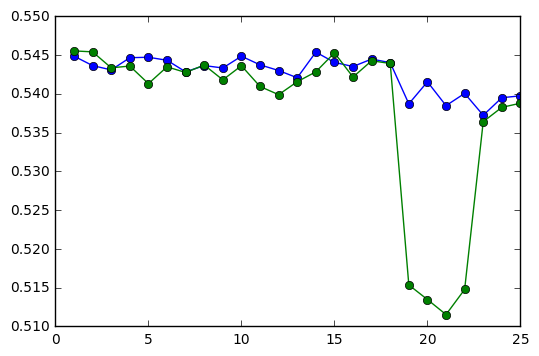

In [125]:
# wykres przewidywalności mid price w zależności od wektoru imbalance
# długości k
plt.plot(np.arange(1,26), skutecznosc, marker = 'o')
plt.show()

In [126]:
skutecznosc1 = np.array(skutecznosc)[:, 0]
skutecznosc2 = np.array(skutecznosc)[:, 1]

In [127]:
print("maks. skuteczność dla danych standardowych: ", np.max(skutecznosc1))
print("dostaliśmy ją dla k = ", np.argmax(skutecznosc1) + 1)
print("maks. skuteczność dla danych znormalizowanych: ", np.max(skutecznosc2))
print("dostaliśmy ją dla k = ", np.argmax(skutecznosc2) + 1)

maks. skuteczność dla danych standardowych:  0.545394431555
dostaliśmy ją dla k =  14
maks. skuteczność dla danych znormalizowanych:  0.545555555556
dostaliśmy ją dla k =  1


In [128]:
# powtórzenie obliczeń dla wszystkich lobów niezależnie od godziny:
X = []
for wiersz in dane:
    newWiersz = wiersz.split()
    X.append(LOB(newWiersz))
X = np.array(X)
zmiana = generujZmiane(X)
Imbalance1 = generujImbalance1(X)

In [129]:
skutecznosc = []
for i in range(1, 26):
    skutecznosc.append(testFewCross(X, i))

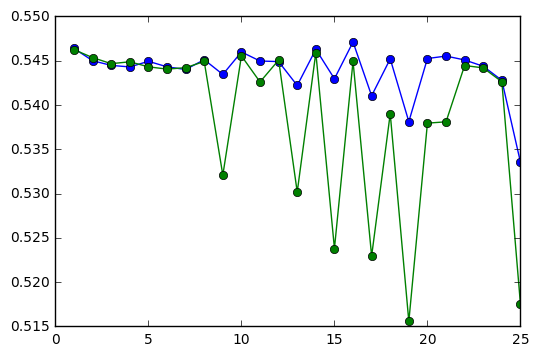

In [130]:
# wykres przewidywalności mid price w zależności od wektoru imbalance
# długości k
plt.plot(np.arange(1,26), skutecznosc, marker = 'o')
plt.show()

In [131]:
skutecznosc1 = np.array(skutecznosc)[:, 0]
skutecznosc2 = np.array(skutecznosc)[:, 1]
print("maks. skuteczność dla danych standardowych: ", np.max(skutecznosc1))
print("dostaliśmy ją dla k = ", np.argmax(skutecznosc1) + 1)
print("maks. skuteczność dla danych znormalizowanych: ", np.max(skutecznosc2))
print("dostaliśmy ją dla k = ", np.argmax(skutecznosc2) + 1)

maks. skuteczność dla danych standardowych:  0.54711517761
dostaliśmy ją dla k =  16
maks. skuteczność dla danych znormalizowanych:  0.546247311828
dostaliśmy ją dla k =  1
